# Importing Libs

In [30]:
import numpy as np

from numpy.random import binomial

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.segmentation import quickshift, mark_boundaries

# Reading Images

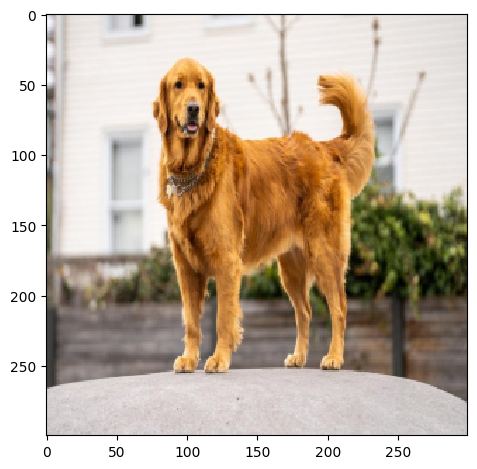

In [31]:
image = imread("images/dog.jpeg")
image = resize(image, (300, 300))
imshow(image)

# Creating mask

In [32]:
image_superpixels = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)
print(len(set(image_superpixels.flatten().tolist()))) # num. de regiões
print(image_superpixels)

68
[[ 5  5  5 ...  0  0  0]
 [ 5  5  5 ...  0  0  0]
 [ 5  5  5 ...  0  0  0]
 ...
 [60 60 60 ... 63 63 63]
 [60 60 60 ... 63 63 63]
 [60 60 60 ... 63 63 63]]


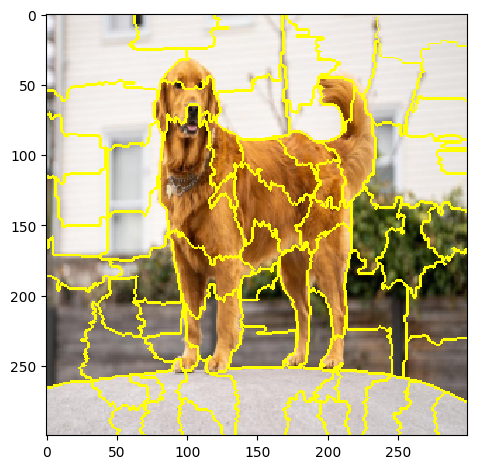

In [33]:
imshow(mark_boundaries(image, image_superpixels))

In [34]:
def gen_image_superpixels(image, kernel_size=4, max_dist=200, ratio=0.2):
    return quickshift(image, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio)

In [35]:
def find_superpixels_size(superpixels):
    return len(set(superpixels.flatten().tolist()))

In [36]:
def gen_superpixel_sample(num_samples, num_superpixels):
    return binomial(1, 0.5, (num_samples, num_superpixels))

In [37]:
def gen_masked_image(image, superpixel_sample, image_superpixels):
    sample_indexes = np.where(superpixel_sample == 1)
    mask = np.isin(image_superpixels, sample_indexes)
    return image * mask[..., None]  # clever way to multiply (W, H, C) * (W, H)  :D

In [38]:
superpixel_sample = gen_superpixel_sample(100, find_superpixels_size(image_superpixels))

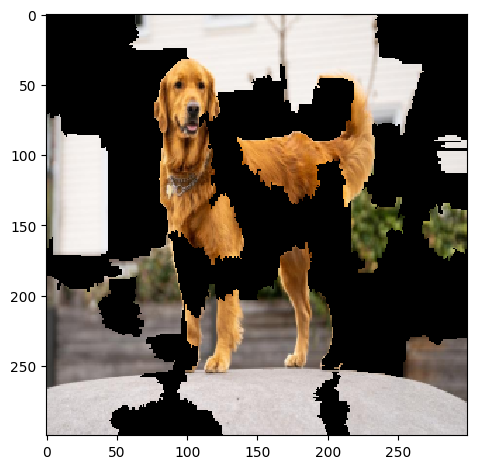

In [39]:
imshow(gen_masked_image(image, superpixel_sample[0], image_superpixels))

# Load ML model

In [40]:
from torch import topk

from torchvision.models import vgg16, VGG16_Weights
from torchvision.transforms import ToTensor, ToPILImage

In [41]:
def numpy_to_torch(image):
    to_tensor = ToTensor()
    tensor_image = to_tensor(image.astype(np.float32))
    return tensor_image.unsqueeze(0)

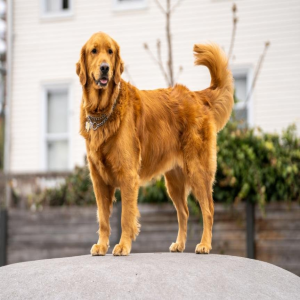

In [42]:
ToPILImage()(numpy_to_torch(image).squeeze(0)) # checking if transform is working

In [43]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

In [44]:
def get_model_preds(model, sample, image):
    masked_image = gen_masked_image(image, sample, image_superpixels)
    tensor_image = numpy_to_torch(masked_image)
    return model(tensor_image)

In [45]:
for sample in superpixel_sample:
    preds = get_model_preds(model, sample, image)
    print(preds.size())
    print(topk(preds, 5))
    break

torch.Size([1, 1000])
torch.return_types.topk(
values=tensor([[9.1160, 8.6188, 8.0244, 7.7799, 7.5837]], grad_fn=<TopkBackward0>),
indices=tensor([[296, 208, 219, 190, 216]]))


# Training Linear Regression Model

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances

from torch import argmax

In [47]:
def find_class_to_explain(model, image, superpixels_num):
    pred = get_model_preds(model, np.ones((superpixels_num, )), image)
    return argmax(pred)

In [48]:
def get_sample_distances(superpixel_sample):
    complete_sample = np.ones_like(superpixel_sample)[0]
    complete_sample = np.expand_dims(complete_sample, axis=0)
    return np.squeeze(pairwise_distances(superpixel_sample, complete_sample, metric='cosine'))

### Fórmula do Kernel: $ \text{kernel}(x) = \sqrt{e^{\frac{- x^2}{k^2}}} $

In [49]:
def get_sample_weights(image_superpixels, kernel_width=0.25):
    sample_distances = get_sample_distances(image_superpixels)
    return np.sqrt(np.exp(- sample_distances**2 / kernel_width**2))

In [50]:
np.ones(find_superpixels_size(image_superpixels))[np.newaxis,:].shape

(1, 68)

In [51]:
def train_linear_model(model, image, num_samples=100, kernel_width=0.25):
    image_superpixels = gen_image_superpixels(image)
    superpixels_num = find_superpixels_size(image_superpixels)
    class_to_explain = find_class_to_explain(model, image, superpixels_num)

    superpixel_sample = gen_superpixel_sample(num_samples, superpixels_num)

    outs = []
    for sample in superpixel_sample:
        pred = get_model_preds(model, sample, image)
        outs.append(pred[0][class_to_explain].detach())

    linear_model = LinearRegression()
    linear_model.fit(X=superpixel_sample, y=outs, sample_weight=get_sample_weights(superpixel_sample, kernel_width))
    
    return linear_model.coef_

In [23]:
coefs = train_linear_model(model, image)

In [24]:
coefs

array([-0.7772067 ,  0.14326501,  0.67647659,  0.4623182 ,  1.11372045,
        1.26056819,  0.35681174,  0.18889047,  0.37553368,  0.2690875 ,
        2.26689353,  0.04628458,  0.19216776, -1.15348269,  0.16475216,
       -0.11786082,  0.17239186,  0.06838482,  0.52452166, -1.23154383,
       -0.14729797, -0.13234026, -0.32738368,  0.24968511, -0.73258762,
       -0.22933448, -0.33848134, -0.83027175,  0.08469698,  0.03336612,
        0.51128516,  0.98052407,  0.41883564,  0.82456016,  1.85787367,
        2.02122425,  0.35229195,  0.38910819, -0.25686226,  0.1708827 ,
        0.91642939,  1.28132532, -0.06598432, -0.35207256, -0.0907984 ,
       -1.10746871,  0.38700968, -0.5172679 , -0.68366923,  0.55277587,
        0.29857553,  0.3984566 , -0.29942498,  0.67032929,  0.76292084,
       -0.53143092, -0.51473593, -0.4350648 ,  1.19372367, -0.41702443,
        0.30298976,  0.90434762, -0.67093213,  0.25538306,  1.19941802,
        0.39320493, -0.17500466,  0.58202303])

In [25]:
num_selected_feats = 4
top_features = np.argsort(coefs)[-num_selected_feats:]
top_features

array([41, 34, 35, 10])

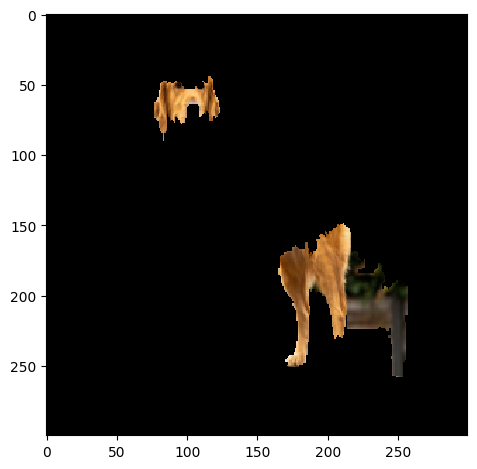

In [26]:
mask = np.zeros_like(superpixel_sample[0])
mask[top_features] = 1
imshow(gen_masked_image(image, mask, image_superpixels))

In [27]:
def lime_image(
        model, 
        image, 
        num_train_iterations=100,
        kernel_width=0.25,
        num_selected_feats=6):
    
    coefs = train_linear_model(model, image, num_samples=num_train_iterations, kernel_width=kernel_width)
    
    top_features = np.argsort(coefs)[-num_selected_feats:]

    mask = np.zeros_like(superpixel_sample[0])
    mask[top_features] = 1
    
    return gen_masked_image(image, mask, image_superpixels)

In [28]:
img = lime_image(model, image, num_train_iterations=250)

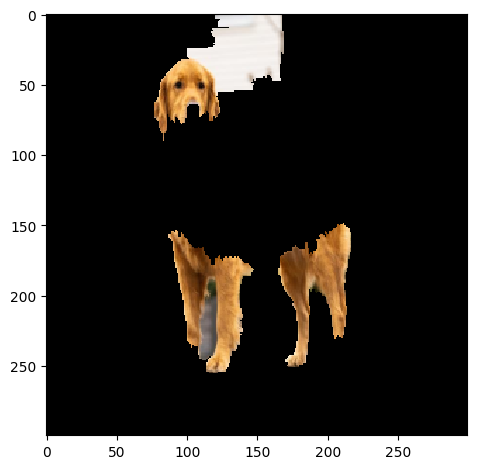

In [29]:
imshow(img)